In [1]:
!nvidia-smi    # GPUの確認, '!'を先頭につけるとシェルコマンドになる

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P data/

--2025-07-08 13:01:26--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
download.pytorch.org (download.pytorch.org) をDNSに問いあわせています... 18.172.31.20, 18.172.31.50, 18.172.31.26, ...
download.pytorch.org (download.pytorch.org)|18.172.31.20|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 47286322 (45M) [application/zip]
‘data/hymenoptera_data.zip.1’ に保存中

hymenoptera_data.zi 100%[===================>]  45.10M  11.0MB/s    in 4.4s    

2025-07-08 13:01:31 (10.1 MB/s) - ‘data/hymenoptera_data.zip.1’ へ保存完了 [47286322/47286322]



In [17]:
# ダウンロードしたzipファイルの解凍
!unzip data/hymenoptera_data.zip -d data/
!ls data

Archive:  data/hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: data/hymenoptera_data/train/

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:
data_dir = os.path.join('data', 'hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

torch.Size([4, 3, 224, 224]) torch.Size([4])


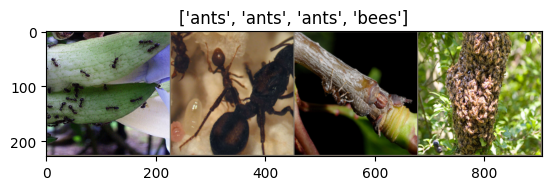

In [20]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.grid(False)
    plt.tick_params(labelbottom="off",bottom="off")    # x軸の削除
    plt.tick_params(labelleft="off",left="off")    # y軸の削除
    if title is not None:
        plt.title(title)

images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())  # torch.Size([4, 3, 224, 224]) torch.Size([4])
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
# 組み込みのモデルを読み込み
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features

# 最終の全結合層を書き換える
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/home/niwako/projects/hw/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.8279 Acc: 0.5000
val Loss: 0.8228 Acc: 0.5686
Epoch 1/24
----------
train Loss: 0.7958 Acc: 0.5574
val Loss: 0.9062 Acc: 0.5556
Epoch 2/24
----------
train Loss: 0.7857 Acc: 0.5984
val Loss: 0.6333 Acc: 0.6928
Epoch 3/24
----------
train Loss: 0.6826 Acc: 0.6189
val Loss: 0.6898 Acc: 0.6340
Epoch 4/24
----------
train Loss: 0.6839 Acc: 0.6311
val Loss: 0.6512 Acc: 0.6601
Epoch 5/24
----------
train Loss: 0.8205 Acc: 0.6066
val Loss: 1.0297 Acc: 0.5882
Epoch 6/24
----------
train Loss: 0.7256 Acc: 0.6107
val Loss: 0.6046 Acc: 0.7059
Epoch 7/24
----------
train Loss: 0.6288 Acc: 0.6352
val Loss: 0.5717 Acc: 0.7124
Epoch 8/24
----------
train Loss: 0.6010 Acc: 0.6557
val Loss: 0.5978 Acc: 0.7255
Epoch 9/24
----------
train Loss: 0.5759 Acc: 0.7049
val Loss: 0.6534 Acc: 0.7059
Epoch 10/24
----------
train Loss: 0.6062 Acc: 0.6475
val Loss: 0.5862 Acc: 0.6993
Epoch 11/24
----------
train Loss: 0.5980 Acc: 0.6762
val Loss: 0.5654 Acc: 0.7124
Epoch 12/24
----------
train Loss: 0

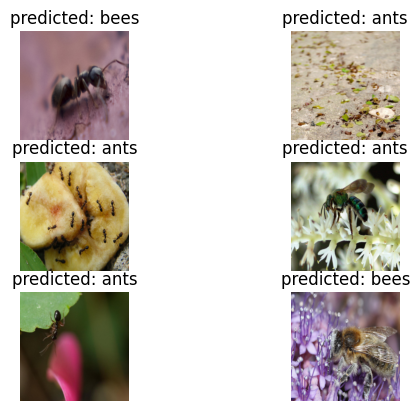

In [25]:
# 学習したモデルの利用
visualize_model(model_ft)

In [26]:
# 学習済みモデルの読み込み
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features

# 最終の全結合層を書き換える
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/niwako/projects/hw/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/niwako/projects/hw/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/niwako/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7187 Acc: 0.6066
val Loss: 0.4732 Acc: 0.7908
Epoch 1/24
----------
train Loss: 0.4970 Acc: 0.7459
val Loss: 0.2109 Acc: 0.9346
Epoch 2/24
----------
train Loss: 0.4253 Acc: 0.8525
val Loss: 0.2367 Acc: 0.9281
Epoch 3/24
----------
train Loss: 0.4644 Acc: 0.7787
val Loss: 0.2181 Acc: 0.9281
Epoch 4/24
----------
train Loss: 0.4798 Acc: 0.8115
val Loss: 0.3857 Acc: 0.8170
Epoch 5/24
----------
train Loss: 0.4641 Acc: 0.7951
val Loss: 0.2152 Acc: 0.9346
Epoch 6/24
----------
train Loss: 0.3489 Acc: 0.8525
val Loss: 0.1794 Acc: 0.9346
Epoch 7/24
----------
train Loss: 0.3289 Acc: 0.8811
val Loss: 0.2179 Acc: 0.9281
Epoch 8/24
----------
train Loss: 0.3089 Acc: 0.8730
val Loss: 0.1961 Acc: 0.9412
Epoch 9/24
----------
train Loss: 0.3513 Acc: 0.8566
val Loss: 0.1908 Acc: 0.9346
Epoch 10/24
----------
train Loss: 0.3707 Acc: 0.8525
val Loss: 0.2405 Acc: 0.9150
Epoch 11/24
----------
train Loss: 0.3948 Acc: 0.8279
val Loss: 0.1986 Acc: 0.9346
Epoch 12/24
--

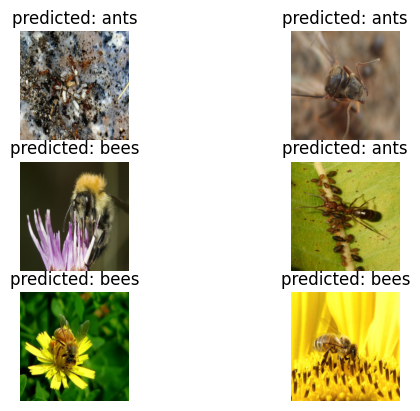

In [28]:
visualize_model(model_ft)